In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection  import KFold
from sklearn.linear_model import Ridge





In [2]:
#thống kê kết quả chạy
FPT_RMSE = []
FPT_MAPE = []
FPT_MAE = []

ELC_RMSE = []
ELC_MAPE = []
ELC_MAE = []

CMG_RMSE = []
CMG_MAPE = []
CMG_MAE = []

# Chia dữ liệu theo tỉ lệ 7:3

## FPT

In [3]:
# Xem data
# Load the data
df = pd.read_csv("FPT-Historical-Data.csv", index_col='Date')

# Convert 'Price' column to numeric type

print(df)

               Price
Date                
2018-03-26   25563.3
2018-03-27   25692.8
2018-03-28   25433.8
2018-03-29   25692.8
2018-03-30   26211.0
...              ...
2024-03-18  113000.0
2024-03-19  112000.0
2024-03-20  114500.0
2024-03-21  116200.0
2024-03-22  114900.0

[2189 rows x 1 columns]


In [4]:

# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 7:3
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing sets
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

base_models = [
    ('svm', SVR()),
    ('rf', RandomForestRegressor(random_state=42)),
]

# Initialize StackingRegressor with base models and meta-learner
model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv=KFold(n_splits=10, shuffle=False)
)

# Fit the StackingRegressor
model.fit(x_train, y_train)





StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7C7D003AE740,
   shuffle=False),
                  estimators=[('svm', SVR()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [5]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)



In [6]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]

# Create an array of 30 60 90 consecutive integers starting from the index after the last data point
next_30_days_index = np.arange(last_index + 1, last_index + 31)
next_60_days_index = np.arange(last_index + 32, last_index + 61)
next_90_days_index = np.arange(last_index + 62, last_index + 91)

# Reshape the indices for prediction
x_next_30_days = next_30_days_index.reshape(-1, 1)
x_next_60_days = next_60_days_index.reshape(-1, 1)
x_next_90_days = next_90_days_index.reshape(-1, 1)

# Predict the closing prices for the next 30 60 and 90 days
y_next_30_days = model.predict(x_next_30_days)
y_next_60_days = model.predict(x_next_60_days)
y_next_90_days = model.predict(x_next_90_days)


last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+61 , stop=last_index+90, step=1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)




Predicted closing prices for the next 30 days:
[90000.03824879 90000.24388056 90000.44813596 90000.65102209
 90000.85254605 90001.05271493 90001.25153576 90001.4490156
 90001.64516145 90001.83998032 90002.03347919 90002.225665
 90002.4165447  90002.6061252  90002.79441341 90002.98141619
 90003.16714041 90003.35159291 90003.53478048 90003.71670994
 90003.89738806 90004.07682158 90004.25501725 90004.43198177
 90004.60772184 90004.78224412 90004.95555527 90005.12766191
 90005.29857065 90005.46828808]


In [7]:
# 7. Đánh giá độ chính xác test
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate each base model
for name, estimator in model.named_estimators_.items():
    y_pred_base = estimator.predict(x_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f'{name} - R^2 Score: {r2_base:.3f}, RMSE: {rmse_base:.3f}')

# 7. Đánh giá độ chính xác test
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape, '%')

# Calculate MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)

FPT_RMSE.append(round(test_rmse,4))
FPT_MAPE.append(round(test_mape,4))
FPT_MAE.append(round(test_mae,4))

svm - R^2 Score: -31.274, RMSE: 53108.462
rf - R^2 Score: -0.446, RMSE: 11239.890
Testing RMSE: 9882.091540400532
Testing MAPE: 10.036636779271916 %
Testing MAE: 8457.197683459171


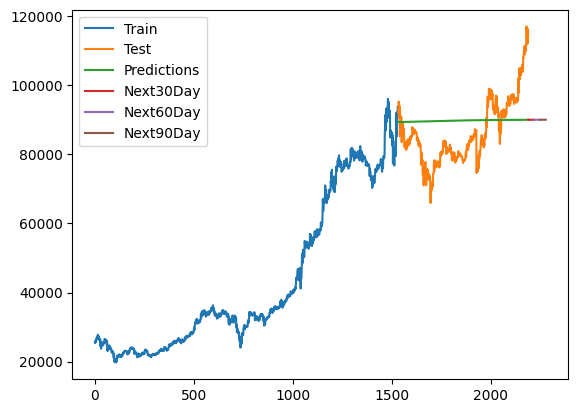

In [8]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

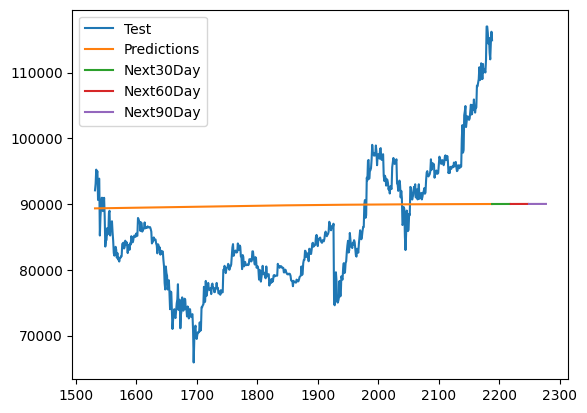

In [9]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

## ELC

In [10]:

# Load the data
df = pd.read_csv("ELC-Historical-Data.csv", index_col='Date')





# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 7:3
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and sets
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

base_models = [
    ('svm', SVR()),
    ('rf', RandomForestRegressor(random_state=42)),
]


# Initialize StackingRegressor with base models and meta-learner
model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv = KFold(n_splits=10, shuffle=False)
)





# Fit the StackingRegressor
model.fit(x_train, y_train)


StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7C7CFE187E40,
   shuffle=False),
                  estimators=[('svm', SVR()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [11]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)

In [12]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]

# Create an array of 30 60 90 consecutive integers starting from the index after the last data point
next_30_days_index = np.arange(last_index + 1, last_index + 31)
next_60_days_index = np.arange(last_index + 32, last_index + 61)
next_90_days_index = np.arange(last_index + 62, last_index + 91)

# Reshape the indices for prediction
x_next_30_days = next_30_days_index.reshape(-1, 1)
x_next_60_days = next_60_days_index.reshape(-1, 1)
x_next_90_days = next_90_days_index.reshape(-1, 1)

# Predict the closing prices for the next 30 60 and 90 days
y_next_30_days = model.predict(x_next_30_days)
y_next_60_days = model.predict(x_next_60_days)
y_next_90_days = model.predict(x_next_90_days)


last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+61 , stop=last_index+90, step=1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[15963.52944716 15963.68846891 15963.84643473 15964.00334997
 15964.15921997 15964.31405003 15964.46784547 15964.62061159
 15964.77235365 15964.92307693 15965.07278667 15965.22148813
 15965.36918651 15965.51588704 15965.66159492 15965.80631532
 15965.95005341 15966.09281436 15966.2346033  15966.37542536
 15966.51528566 15966.65418928 15966.79214133 15966.92914686
 15967.06521093 15967.20033859 15967.33453486 15967.46780474
 15967.60015324 15967.73158534]


In [13]:
# 7. Đánh giá độ chính xác test
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate each base model
for name, estimator in model.named_estimators_.items():
    y_pred_base = estimator.predict(x_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f'{name} - R^2 Score: {r2_base:.3f}, RMSE: {rmse_base:.3f}')

# 7. Đánh giá độ chính xác  test
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape, '%')

# Calculate MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)

ELC_RMSE.append(round(test_rmse,4))
ELC_MAPE.append(round(test_mape,4))
ELC_MAE.append(round(test_mae,4))

svm - R^2 Score: -3.193, RMSE: 10563.682
rf - R^2 Score: -0.022, RMSE: 5214.275
Testing RMSE: 5061.4100092249855
Testing MAPE: 30.22681958430572 %
Testing MAE: 4383.889300538292


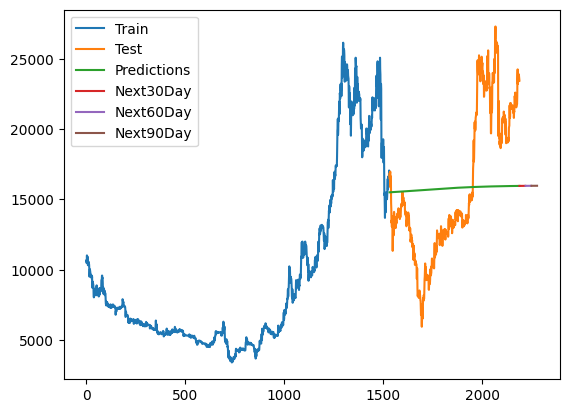

In [14]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

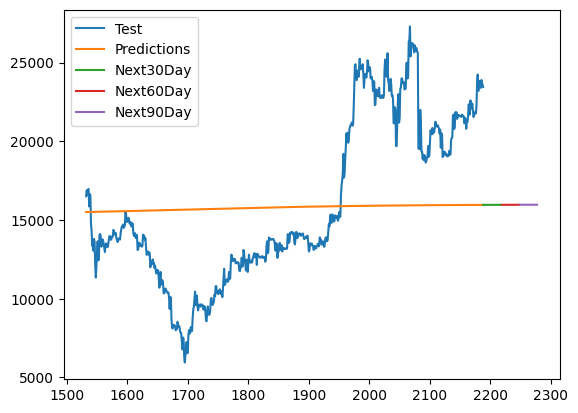

In [15]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

## CMG

In [16]:
# Load the data
df = pd.read_csv("CMG-Historical-Data.csv", index_col='Date')




# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 7:3
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and sets
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

base_models = [
    ('svm', SVR()),
    ('rf', RandomForestRegressor(random_state=42)),
]



# Initialize StackingRegressor with base models and meta-learner
model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv = KFold(n_splits=10, shuffle=False)
)





# Fit the StackingRegressor
model.fit(x_train, y_train)


StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7C7CF9A38140,
   shuffle=False),
                  estimators=[('svm', SVR()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [17]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)

In [18]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]

# Create an array of 30 60 90 consecutive integers starting from the index after the last data point
next_30_days_index = np.arange(last_index + 1, last_index + 31)
next_60_days_index = np.arange(last_index + 32, last_index + 61)
next_90_days_index = np.arange(last_index + 62, last_index + 91)

# Reshape the indices for prediction
x_next_30_days = next_30_days_index.reshape(-1, 1)
x_next_60_days = next_60_days_index.reshape(-1, 1)
x_next_90_days = next_90_days_index.reshape(-1, 1)

# Predict the closing prices for the next 30 60 and 90 days
y_next_30_days = model.predict(x_next_30_days)
y_next_60_days = model.predict(x_next_60_days)
y_next_90_days = model.predict(x_next_90_days)


last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+61 , stop=last_index+90, step=1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[53686.32660888 53686.52922542 53686.73050019 53686.93043995
 53687.12905144 53687.32634137 53687.52231645 53687.71698337
 53687.9103488  53688.1024194  53688.2932018  53688.48270263
 53688.67092848 53688.85788596 53689.04358163 53689.22802204
 53689.41121372 53689.59316321 53689.773877   53689.95336157
 53690.13162339 53690.30866891 53690.48450456 53690.65913676
 53690.83257188 53691.00481633 53691.17587644 53691.34575856
 53691.51446901 53691.6820141 ]
Predicted closing prices for the next 30 days:
[53686.32660888 53686.52922542 53686.73050019 53686.93043995
 53687.12905144 53687.32634137 53687.52231645 53687.71698337
 53687.9103488  53688.1024194  53688.2932018  53688.48270263
 53688.67092848 53688.85788596 53689.04358163 53689.22802204
 53689.41121372 53689.59316321 53689.773877   53689.95336157
 53690.13162339 53690.30866891 53690.48450456 53690.65913676
 53690.83257188 53691.00481633 53691.17587644 53691.34575856
 53691.51446901 5369

In [19]:
# 7. Đánh giá độ chính xác test
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate each base model
for name, estimator in model.named_estimators_.items():
    y_pred_base = estimator.predict(x_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f'{name} - R^2 Score: {r2_base:.3f}, RMSE: {rmse_base:.3f}')

# 7. Đánh giá độ chính xác test
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape, '%')

# Calculate MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)

CMG_RMSE.append(round(test_rmse,4))
CMG_MAPE.append(round(test_mape,4))
CMG_MAE.append(round(test_mae,4))

svm - R^2 Score: -10.288, RMSE: 18237.395
rf - R^2 Score: -2.383, RMSE: 9984.312
Testing RMSE: 10367.264868084643
Testing MAPE: 22.070870662300802 %
Testing MAE: 9170.91226521759


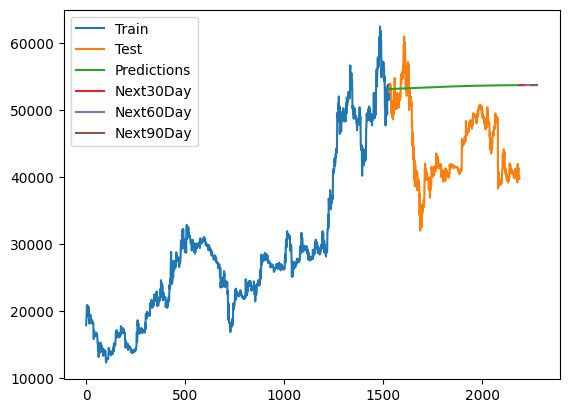

In [20]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

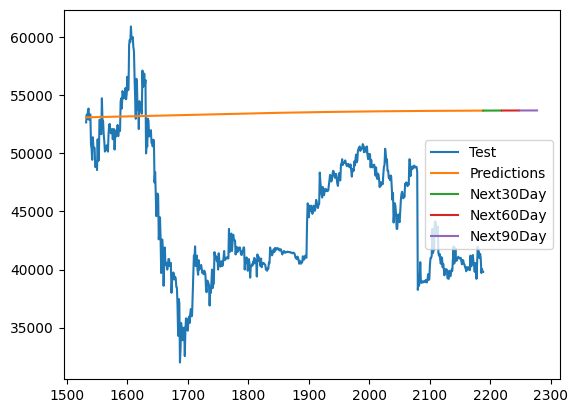

In [21]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Chia dữ liệu theo tỉ lệ 8:2

## FPT

In [22]:
# Xem data
# Load the data
df = pd.read_csv("FPT-Historical-Data.csv", index_col='Date')


print(df)

               Price
Date                
2018-03-26   25563.3
2018-03-27   25692.8
2018-03-28   25433.8
2018-03-29   25692.8
2018-03-30   26211.0
...              ...
2024-03-18  113000.0
2024-03-19  112000.0
2024-03-20  114500.0
2024-03-21  116200.0
2024-03-22  114900.0

[2189 rows x 1 columns]


In [23]:

# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 8:2
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

base_models = [
    ('svm', SVR()),
    ('rf', RandomForestRegressor(random_state=42)),
]

# Initialize StackingRegressor with base models and meta-learner
model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv=KFold(n_splits=10, shuffle=False)
)

# Fit the StackingRegressor
model.fit(x_train, y_train)





StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7C7CF9A38E40,
   shuffle=False),
                  estimators=[('svm', SVR()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [24]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)



In [25]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]

# Create an array of 30 60 90 consecutive integers starting from the index after the last data point
next_30_days_index = np.arange(last_index + 1, last_index + 31)
next_60_days_index = np.arange(last_index + 32, last_index + 61)
next_90_days_index = np.arange(last_index + 62, last_index + 91)

# Reshape the indices for prediction
x_next_30_days = next_30_days_index.reshape(-1, 1)
x_next_60_days = next_60_days_index.reshape(-1, 1)
x_next_90_days = next_90_days_index.reshape(-1, 1)

# Predict the closing prices for the next 30 60 and 90 days
y_next_30_days = model.predict(x_next_30_days)
y_next_60_days = model.predict(x_next_60_days)
y_next_90_days = model.predict(x_next_90_days)


last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+61 , stop=last_index+90, step=1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)





Predicted closing prices for the next 30 days:
[79663.77867732 79664.0441194  79664.30866083 79664.57230255
 79664.83504548 79665.09689056 79665.35783876 79665.61789103
 79665.87704836 79666.13531173 79666.39268214 79666.64916061
 79666.90474817 79667.15944584 79667.41325467 79667.66617573
 79667.91821007 79668.16935878 79668.41962295 79668.66900368
 79668.91750209 79669.16511928 79669.41185641 79669.65771461
 79669.90269503 79670.14679884 79670.39002722 79670.63238136
 79670.87386244 79671.11447167]


In [26]:
# 7. Đánh giá độ chính xác test
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate each base model
for name, estimator in model.named_estimators_.items():
    y_pred_base = estimator.predict(x_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f'{name} - R^2 Score: {r2_base:.3f}, RMSE: {rmse_base:.3f}')

# 7. Đánh giá độ chính xác test
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape, '%')

# Calculate MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)

FPT_RMSE.append(round(test_rmse,4))
FPT_MAPE.append(round(test_mape,4))
FPT_MAE.append(round(test_mae,4))

svm - R^2 Score: -32.370, RMSE: 54625.663
rf - R^2 Score: -0.888, RMSE: 12992.123
Testing RMSE: 13367.587432556204
Testing MAPE: 10.207553514044521 %
Testing MAE: 9875.04872285476


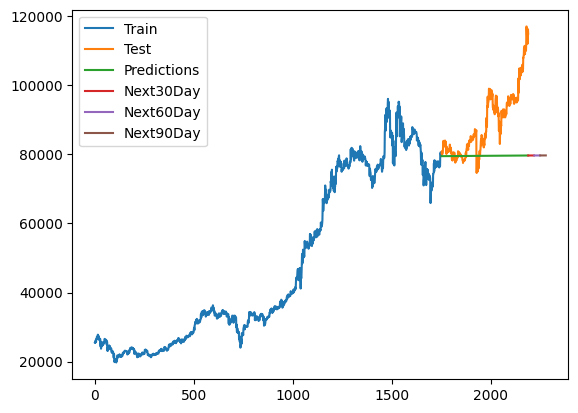

In [27]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

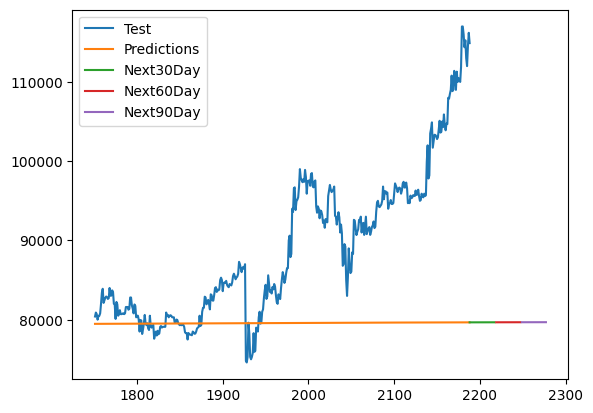

In [28]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

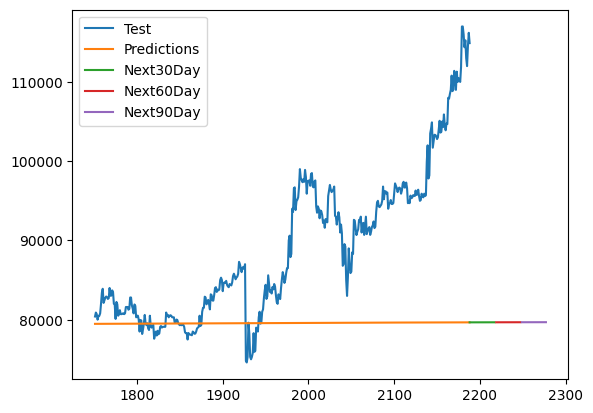

In [29]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

## ELC

In [30]:

# Load the data
df = pd.read_csv("ELC-Historical-Data.csv", index_col='Date')





# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 8:2
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

base_models = [
    ('svm', SVR()),
    ('rf', RandomForestRegressor(random_state=42)),
]
# Initialize StackingRegressor with base models and meta-learner
model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv = KFold(n_splits=10, shuffle=False)
)





# Fit the StackingRegressor
model.fit(x_train, y_train)


StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7C7CF9A38840,
   shuffle=False),
                  estimators=[('svm', SVR()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [31]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)

In [32]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]

# Create an array of 30 60 90 consecutive integers starting from the index after the last data point
next_30_days_index = np.arange(last_index + 1, last_index + 31)
next_60_days_index = np.arange(last_index + 32, last_index + 61)
next_90_days_index = np.arange(last_index + 62, last_index + 91)

# Reshape the indices for prediction
x_next_30_days = next_30_days_index.reshape(-1, 1)
x_next_60_days = next_60_days_index.reshape(-1, 1)
x_next_90_days = next_90_days_index.reshape(-1, 1)

# Predict the closing prices for the next 30 60 and 90 days
y_next_30_days = model.predict(x_next_30_days)
y_next_60_days = model.predict(x_next_60_days)
y_next_90_days = model.predict(x_next_90_days)


last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+61 , stop=last_index+90, step=1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[10399.93060124 10400.3245267  10400.71705144 10401.10817718
 10401.49790565 10401.88623861 10402.27317784 10402.65872512
 10403.04288227 10403.42565112 10403.80703351 10404.1870313
 10404.56564639 10404.94288066 10405.31873603 10405.69321445
 10406.06631785 10406.43804821 10406.80840751 10407.17739775
 10407.54502095 10407.91127915 10408.27617439 10408.63970874
 10409.00188429 10409.36270313 10409.72216738 10410.08027916
 10410.43704063 10410.79245394]


In [33]:
# 7. Đánh giá độ chính xác test
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate each base model
for name, estimator in model.named_estimators_.items():
    y_pred_base = estimator.predict(x_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f'{name} - R^2 Score: {r2_base:.3f}, RMSE: {rmse_base:.3f}')

# 7. Đánh giá độ chính xác  test
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape, '%')

# Calculate MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)

ELC_RMSE.append(round(test_rmse,4))
ELC_MAPE.append(round(test_mape,4))
ELC_MAE.append(round(test_mae,4))

svm - R^2 Score: -4.491, RMSE: 11302.642
rf - R^2 Score: -2.509, RMSE: 9035.510
Testing RMSE: 9079.949522558682
Testing MAPE: 38.62959150889332 %
Testing MAE: 7737.202467854387


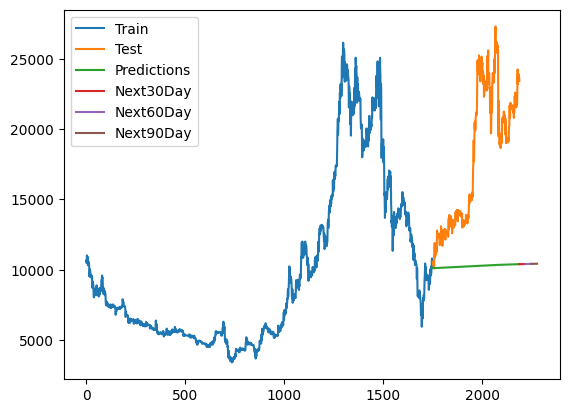

In [34]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

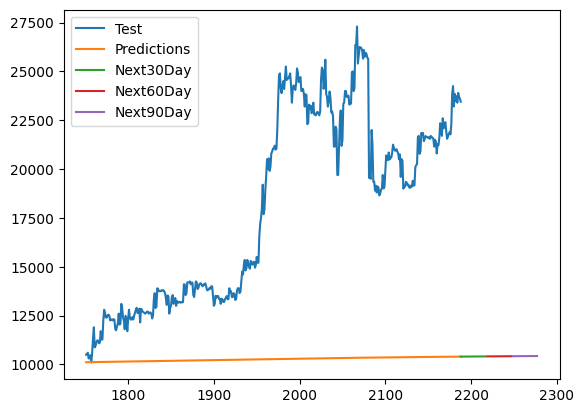

In [35]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

## CMG

In [36]:
# Load the data
df = pd.read_csv("CMG-Historical-Data.csv", index_col='Date')




# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 8:2
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

base_models = [
    ('svm', SVR()),
    ('rf', RandomForestRegressor(random_state=42)),
]

# Initialize StackingRegressor with base models and meta-learner
model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv = KFold(n_splits=10, shuffle=False)
)





# Fit the StackingRegressor
model.fit(x_train, y_train)


StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7C7CF9A39940,
   shuffle=False),
                  estimators=[('svm', SVR()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [37]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)

In [38]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]

# Create an array of 30 60 90 consecutive integers starting from the index after the last data point
next_30_days_index = np.arange(last_index + 1, last_index + 31)
next_60_days_index = np.arange(last_index + 32, last_index + 61)
next_90_days_index = np.arange(last_index + 62, last_index + 91)

# Reshape the indices for prediction
x_next_30_days = next_30_days_index.reshape(-1, 1)
x_next_60_days = next_60_days_index.reshape(-1, 1)
x_next_90_days = next_90_days_index.reshape(-1, 1)

# Predict the closing prices for the next 30 60 and 90 days
y_next_30_days = model.predict(x_next_30_days)
y_next_60_days = model.predict(x_next_60_days)
y_next_90_days = model.predict(x_next_90_days)


last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+61 , stop=last_index+90, step=1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[38831.0064873  38832.61385247 38834.21601061 38835.81296451
 38837.40471704 38838.99127118 38840.57262998 38842.14879659
 38843.71977425 38845.28556628 38846.84617609 38848.40160719
 38849.95186315 38851.49694766 38853.03686448 38854.57161744
 38856.10121048 38857.62564761 38859.14493293 38860.65907062
 38862.16806494 38863.67192024 38865.17064095 38866.66423157
 38868.1526967  38869.63604101 38871.11426925 38872.58738624
 38874.0553969  38875.51830621]


In [39]:
# 7. Đánh giá độ chính xác test
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate each base model
for name, estimator in model.named_estimators_.items():
    y_pred_base = estimator.predict(x_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f'{name} - R^2 Score: {r2_base:.3f}, RMSE: {rmse_base:.3f}')

# 7. Đánh giá độ chính xác test
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape, '%')

# Calculate MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)

CMG_RMSE.append(round(test_rmse,4))
CMG_MAPE.append(round(test_mape,4))
CMG_MAE.append(round(test_mae,4))

svm - R^2 Score: -17.420, RMSE: 15800.125
rf - R^2 Score: -0.844, RMSE: 4998.753
Testing RMSE: 6545.374315804254
Testing MAPE: 11.806823653947689 %
Testing MAE: 5428.358973447781


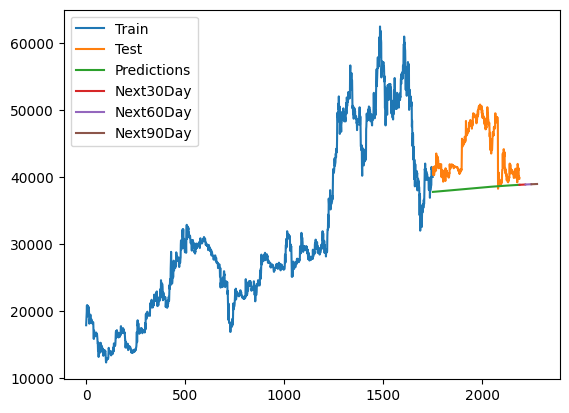

In [40]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

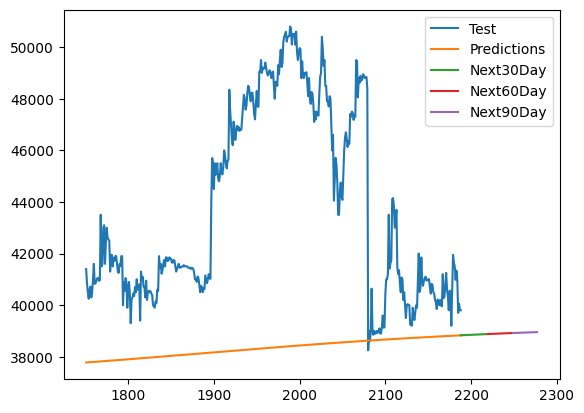

In [41]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Chia dữ liệu theo tỉ lệ 9:1

## FPT

In [42]:
# Xem data
# Load the data
df = pd.read_csv("FPT-Historical-Data.csv", index_col='Date')


print(df)

               Price
Date                
2018-03-26   25563.3
2018-03-27   25692.8
2018-03-28   25433.8
2018-03-29   25692.8
2018-03-30   26211.0
...              ...
2024-03-18  113000.0
2024-03-19  112000.0
2024-03-20  114500.0
2024-03-21  116200.0
2024-03-22  114900.0

[2189 rows x 1 columns]


In [43]:

# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 9:1
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing sets
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

base_models = [
    ('svm', SVR()),
    ('rf', RandomForestRegressor(random_state=42)),
]

# Initialize StackingRegressor with base models and meta-learner
model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv=KFold(n_splits=10, shuffle=False)
)

# Fit the StackingRegressor
model.fit(x_train, y_train)





StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7C7CF9A39140,
   shuffle=False),
                  estimators=[('svm', SVR()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [44]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)



In [45]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]

# Create an array of 30 60 90 consecutive integers starting from the index after the last data point
next_30_days_index = np.arange(last_index + 1, last_index + 31)
next_60_days_index = np.arange(last_index + 32, last_index + 61)
next_90_days_index = np.arange(last_index + 62, last_index + 91)

# Reshape the indices for prediction
x_next_30_days = next_30_days_index.reshape(-1, 1)
x_next_60_days = next_60_days_index.reshape(-1, 1)
x_next_90_days = next_90_days_index.reshape(-1, 1)

# Predict the closing prices for the next 30 60 and 90 days
y_next_30_days = model.predict(x_next_30_days)
y_next_60_days = model.predict(x_next_60_days)
y_next_90_days = model.predict(x_next_90_days)


last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+61 , stop=last_index+90, step=1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)





Predicted closing prices for the next 30 days:
[81276.59567204 81277.01861452 81277.44104941 81277.86297426
 81278.28438667 81278.70528423 81279.12566455 81279.54552527
 81279.96486401 81280.38367842 81280.80196618 81281.21972495
 81281.63695243 81282.05364631 81282.46980432 81282.88542418
 81283.30050363 81283.71504043 81284.12903235 81284.54247716
 81284.95537267 81285.36771667 81285.77950699 81286.19074147
 81286.60141794 81287.01153427 81287.42108833 81287.83007801
 81288.23850121 81288.64635583]


In [46]:
# 7. Đánh giá độ chính xác test
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate each base model
for name, estimator in model.named_estimators_.items():
    y_pred_base = estimator.predict(x_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f'{name} - R^2 Score: {r2_base:.3f}, RMSE: {rmse_base:.3f}')

# 7. Đánh giá độ chính xác test
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape, '%')

# Calculate MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)

FPT_RMSE.append(round(test_rmse,4))
FPT_MAPE.append(round(test_mape,4))
FPT_MAE.append(round(test_mae,4))


svm - R^2 Score: -66.450, RMSE: 57791.789
rf - R^2 Score: -3.007, RMSE: 14086.382
Testing RMSE: 17167.12835540179
Testing MAPE: 15.752122473570893 %
Testing MAE: 15667.94725272375


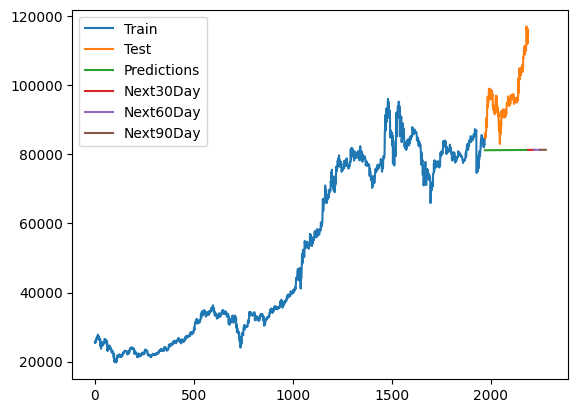

In [47]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

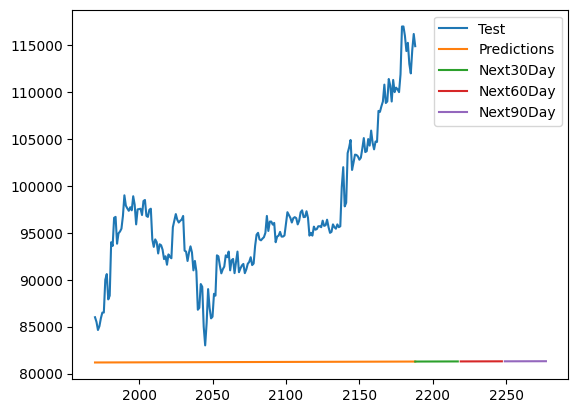

In [48]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

## ELC

In [49]:

# Load the data
df = pd.read_csv("ELC-Historical-Data.csv", index_col='Date')





# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 9:1
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing sets
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

base_models = [
    ('svm', SVR()),
    ('rf', RandomForestRegressor(random_state=42)),
]
# Initialize StackingRegressor with base models and meta-learner
model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv = KFold(n_splits=10, shuffle=False)
)





# Fit the StackingRegressor
model.fit(x_train, y_train)


StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7C7CF9A39640,
   shuffle=False),
                  estimators=[('svm', SVR()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [50]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)

In [51]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]

# Create an array of 30 60 90 consecutive integers starting from the index after the last data point
next_30_days_index = np.arange(last_index + 1, last_index + 31)
next_60_days_index = np.arange(last_index + 32, last_index + 61)
next_90_days_index = np.arange(last_index + 62, last_index + 91)

# Reshape the indices for prediction
x_next_30_days = next_30_days_index.reshape(-1, 1)
x_next_60_days = next_60_days_index.reshape(-1, 1)
x_next_90_days = next_90_days_index.reshape(-1, 1)

# Predict the closing prices for the next 30 60 and 90 days
y_next_30_days = model.predict(x_next_30_days)
y_next_60_days = model.predict(x_next_60_days)
y_next_90_days = model.predict(x_next_90_days)


last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+61 , stop=last_index+90, step=1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[18945.91759541 18947.3128747  18948.70655411 18950.09862555
 18951.48908097 18952.87791238 18954.26511182 18955.65067137
 18957.03458315 18958.41683933 18959.79743213 18961.1763538
 18962.55359663 18963.92915296 18965.30301518 18966.6751757
 18968.045627   18969.41436159 18970.78137201 18972.14665086
 18973.51019078 18974.87198445 18976.23202459 18977.59030396
 18978.94681538 18980.30155169 18981.65450579 18983.00567061
 18984.35503913 18985.70260438]


In [52]:
# 7. Đánh giá độ chính xác test
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate each base model
for name, estimator in model.named_estimators_.items():
    y_pred_base = estimator.predict(x_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f'{name} - R^2 Score: {r2_base:.3f}, RMSE: {rmse_base:.3f}')

# 7. Đánh giá độ chính xác  test
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape, '%')

# Calculate MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)

ELC_RMSE.append(round(test_rmse,4))
ELC_MAPE.append(round(test_mape,4))
ELC_MAE.append(round(test_mae,4))

svm - R^2 Score: -43.763, RMSE: 13719.015
rf - R^2 Score: -0.471, RMSE: 2486.749
Testing RMSE: 4170.295729512133
Testing MAPE: 15.384981296686401 %
Testing MAE: 3608.60683620268


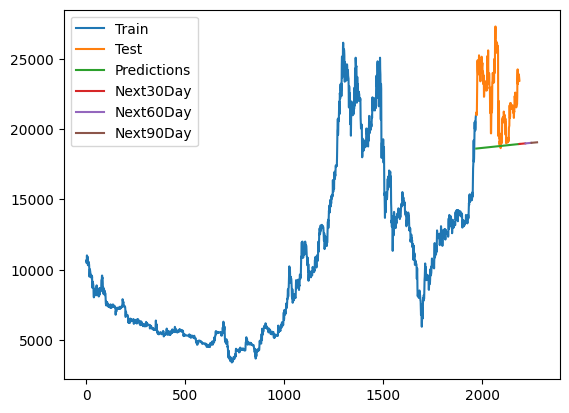

In [53]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

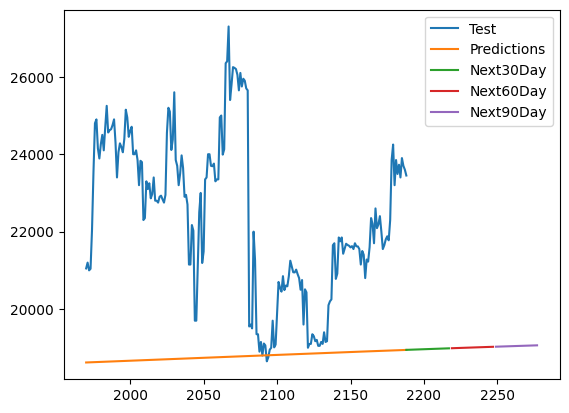

In [54]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

## CMG

In [55]:
# Load the data
df = pd.read_csv("CMG-Historical-Data.csv", index_col='Date')





# 2. Đọc file dữ liệu và chia train test theo tỉ lệ 9:1
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing sets
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

base_models = [
    ('svm', SVR()),
    ('rf', RandomForestRegressor(random_state=42)),
]

# Initialize StackingRegressor with base models and meta-learner
model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv = KFold(n_splits=10, shuffle=False)
)





# Fit the StackingRegressor
model.fit(x_train, y_train)


StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7C7CF9A39E40,
   shuffle=False),
                  estimators=[('svm', SVR()),
                              ('rf', RandomForestRegressor(random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [56]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)

In [57]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]

# Create an array of 30 60 90 consecutive integers starting from the index after the last data point
next_30_days_index = np.arange(last_index + 1, last_index + 31)
next_60_days_index = np.arange(last_index + 32, last_index + 61)
next_90_days_index = np.arange(last_index + 62, last_index + 91)

# Reshape the indices for prediction
x_next_30_days = next_30_days_index.reshape(-1, 1)
x_next_60_days = next_60_days_index.reshape(-1, 1)
x_next_90_days = next_90_days_index.reshape(-1, 1)

# Predict the closing prices for the next 30 60 and 90 days
y_next_30_days = model.predict(x_next_30_days)
y_next_60_days = model.predict(x_next_60_days)
y_next_90_days = model.predict(x_next_90_days)


last_data_30 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_60 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data_90 = pd.RangeIndex(start=last_index+61 , stop=last_index+90, step=1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[46932.52634826 46934.47262223 46936.41714681 46938.35990683
 46940.3008872  46942.24007291 46944.177449   46946.11300059
 46948.04671289 46949.97857115 46951.90856072 46953.83666699
 46955.76287546 46957.68717167 46959.60954125 46961.52996989
 46963.44844336 46965.3649475  46967.27946821 46969.19199148
 46971.10250337 46973.01099    46974.91743757 46976.82183235
 46978.72416069 46980.624409   46982.52256376 46984.41861155
 46986.31253898 46988.20433277]


In [58]:
# 7. Đánh giá độ chính xác test
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate each base model
for name, estimator in model.named_estimators_.items():
    y_pred_base = estimator.predict(x_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f'{name} - R^2 Score: {r2_base:.3f}, RMSE: {rmse_base:.3f}')

# 7. Đánh giá độ chính xác test
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape, '%')

# Calculate MAE
test_mae = np.mean(np.abs(y_pred - y_test))
print('Testing MAE:', test_mae)

CMG_RMSE.append(round(test_rmse,4))
CMG_MAPE.append(round(test_mape,4))
CMG_MAE.append(round(test_mae,4))

svm - R^2 Score: -12.495, RMSE: 15234.357
rf - R^2 Score: -1.264, RMSE: 6240.468
Testing RMSE: 4865.939461000457
Testing MAPE: 10.04311750027476 %
Testing MAE: 4224.442424800252


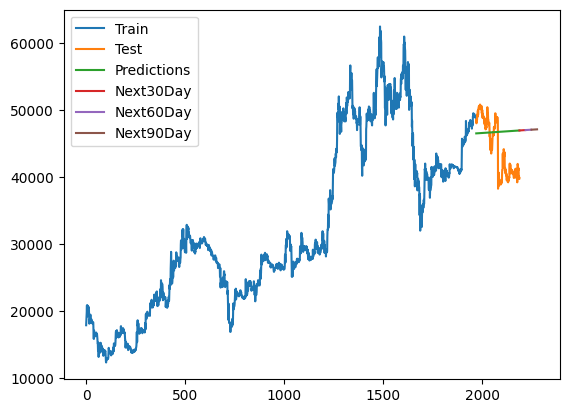

In [59]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

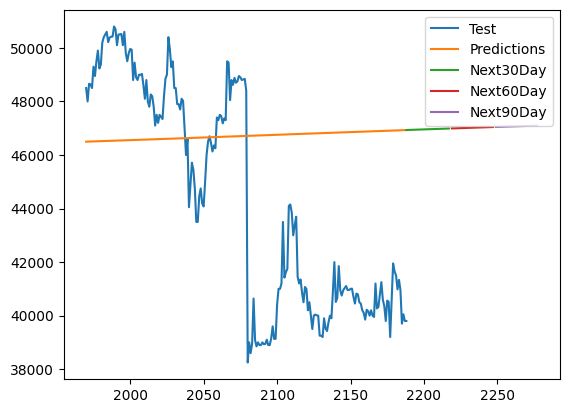

In [60]:
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30,y_next_30_days)
plt.plot(last_data_60,y_next_60_days)
plt.plot(last_data_90,y_next_90_days)
plt.legend([ 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Kết quả

In [61]:
# Function to print the arrays in the required format
def print_metrics(name, RMSE, MAPE, MAE):
    print(f"{name}: ")
    print(f"{'RMSE':<15}{'MAPE':<10}{'MAE':<10}")
    for i in range(len(RMSE)):
        print(f"{RMSE[i]:<15}{MAPE[i]:<10}{MAE[i]:<10}")
    print()  # New line for separation

# Print the metrics for FPT, ELC, and CMG
print_metrics("FPT", FPT_RMSE, FPT_MAPE, FPT_MAE)
print_metrics("ELC", ELC_RMSE, ELC_MAPE, ELC_MAE)
print_metrics("CMG", CMG_RMSE, CMG_MAPE, CMG_MAE)

FPT: 
RMSE           MAPE      MAE       
9882.0915      10.0366   8457.1977 
13367.5874     10.2076   9875.0487 
17167.1284     15.7521   15667.9473

ELC: 
RMSE           MAPE      MAE       
5061.41        30.2268   4383.8893 
9079.9495      38.6296   7737.2025 
4170.2957      15.385    3608.6068 

CMG: 
RMSE           MAPE      MAE       
10367.2649     22.0709   9170.9123 
6545.3743      11.8068   5428.359  
4865.9395      10.0431   4224.4424 

